<h1 style="color:green;"> Data modelling </h1>


<h3> Import necessary libraries </h3>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder, MinMaxScaler, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

ModuleNotFoundError: No module named 'pandas'

<h3> Chúng ta sẽ nhìn lại tập dữ liệu sau quá trình tiền xử lý và khai thác </h3>

In [ ]:
cleaned_df = pd.read_csv('processed_data.csv')

In [ ]:
cleaned_df.head(10)

,Title,Genre,withDLC,isMature,Developer,Publisher,PositiveReviews,TotalReviews,NegativeReviews,Price,ReleaseYear,ReleaseMonth,ReleaseDay,Rating
0,Endless Monday: Dreams and Deadlines,"Adventure, Indie",0,0,hcnone,hcnone,737,737,0,142000.0,2023,5,4,0.931514
1,Papa's Freezeria Deluxe,"Action, Casual, Indie, Simulation, Strategy",0,0,Flipline Studios,Flipline Studios,6514,6562,48,87500.0,2023,3,31,0.957730
2,Cats Hidden in Jingle Jam,"Casual, Indie, Free to Play",0,0,Travellin Cats,Travellin Cats,5097,5108,11,0.0,2023,12,1,0.959760
3,An Arcade Full of Cats,"Casual, Indie, Free to Play",1,0,Devcats,Devcats,3018,3045,27,0.0,2023,11,16,0.947230
4,Ib,"Adventure, Indie",0,0,kouri,PLAYISM,3068,3098,30,150000.0,2022,4,11,0.946714
5,Lil Gator Game,"Action, Adventure, Casual, Indie",0,0,MegaWobble,Playtonic Friends,3363,3395,32,260000.0,2022,12,14,0.948134
6,星空列车与白的旅行,Adventure,1,1,しらたまこ,inc.ZOFE,3056,3083,27,188000.0,2021,5,14,0.947493
7,Patrick's Parabox,"Casual, Indie, Strategy",1,0,Patrick Traynor,Patrick Traynor,2800,2820,20,260000.0,2022,3,29,0.947817
8,A Castle Full of Cats,"Adventure, Casual",1,0,Devcats,Devcats,2512,2526,14,36000.0,2022,11,9,0.947701
9,Dialtown: Phone Dating Sim,"Casual, Indie",1,1,DirectDoggo,DirectDoggo,1316,1324,8,115000.0,2022,2,14,0.937228


### Để có thể nhìn nhận rõ mối quan hệ giữa các cột lý tưởng để làm feature cho model và cột target **Rating**, ta sẽ dùng **Mutual Information** 

#### Ta nhận thấy cột '**Title**' chỉ đơn giản là các giá trị thể hiện tên của các trò chơi điện tử trong tập dữ liệu, ta có thể suy đoán nó không mang lại ý nghĩa hay mối quan hệ gì với cột target '**Rating**'

In [ ]:
cleaned_df.drop(columns = ['Title'], inplace = True)

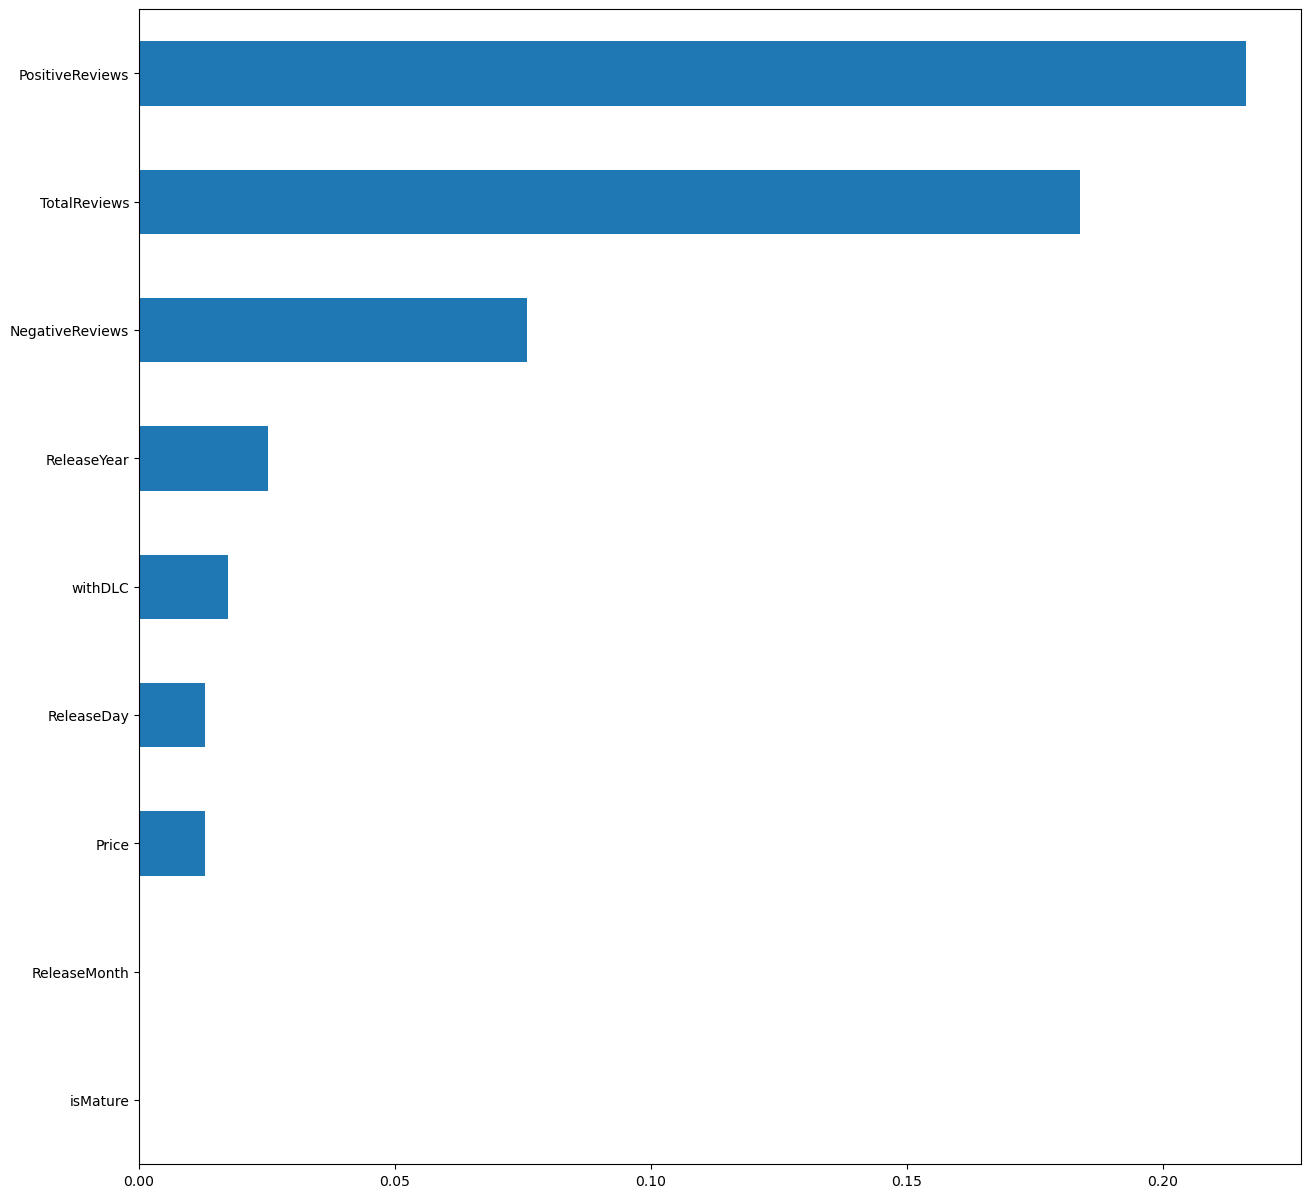

In [ ]:
X = cleaned_df.drop(columns = 'Rating')
y = cleaned_df['Rating']
numeric_X = X.select_dtypes(include='number')
mi_scores = mutual_info_regression(numeric_X, y)
mi_scores = pd.Series(mi_scores, index = numeric_X.columns).sort_values(ascending = True)

plt.figure(figsize = (15, 15))
mi_scores.plot.barh()
plt.show()

#### Ta có thể thấy mặc dù cột '**Genre**' có sự ảnh hưởng đến '**Rating**' hay không thì tại vì sau khi one-hot encode nó cùng với các giá trị khác biệt rất cao, mỗi cột 'Genre_*' đại diện cho một giá trị đấy nên đã kéo thấp giá trị mutual information

Phải chăng ngày phát hành thật sự không ảnh hưởng gì đến Rating của game ta sẽ phân ra model dựa trên các features có bao gồm Release Date và model không dựa trên

## Pipeline cho bước tiền xử lí
Đầu tiên, ta sẽ tìm những cột dữ liệu không là kiểu dữ liệu số:

In [ ]:
cat_df = cleaned_df.select_dtypes(include='object')
cat_df

,Genre,Developer,Publisher
0,"Adventure, Indie",hcnone,hcnone
1,"Action, Casual, Indie, Simulation, Strategy",Flipline Studios,Flipline Studios
2,"Casual, Indie, Free to Play",Travellin Cats,Travellin Cats
3,"Casual, Indie, Free to Play",Devcats,Devcats
4,"Adventure, Indie",kouri,PLAYISM
...,...,...,...
2719,"Adventure, Indie",Gugames,Gugames
2720,"Action, Casual",Zanthous,Zanthous
2721,Adventure,Eyeguys,Santa Ragione
2722,"Action, Adventure, Casual, Indie, Sports",Agera Games,Vertigo Games


Do `Genre` là cột mà mỗi sample có thể có một hoặc nhiều thể loại, do đó phương pháp encoding phù hợp nhất hiện tại là `One Hot Encoding`.
Ta có 2 cột `Developer` và `Publisher` là 2 cột không phải là dữ liệu số, ta sẽ tiến hành encode 2 cột này bằng `TargetEncoder`. Lí do không sử dụng One hot encoding do lo ngại việc quá nhiều cột ảnh hưởng đến hiệu năng của mô hình.

Ta scale các cột dữ liệu số cho model (Những cột có tiền tố `Genre` sẽ không được đưa vào vì nó là những cột `category` được encode, không phải là dữ liệu số thuần túy).

In [ ]:
numeric_df = X.select_dtypes(include='number')
numeric_df

,withDLC,isMature,PositiveReviews,TotalReviews,NegativeReviews,Price,ReleaseYear,ReleaseMonth,ReleaseDay
0,0,0,737,737,0,142000.0,2023,5,4
1,0,0,6514,6562,48,87500.0,2023,3,31
2,0,0,5097,5108,11,0.0,2023,12,1
3,1,0,3018,3045,27,0.0,2023,11,16
4,0,0,3068,3098,30,150000.0,2022,4,11
...,...,...,...,...,...,...,...,...,...
2719,0,0,61,61,0,170000.0,2023,11,10
2720,0,0,34,34,0,59000.0,2023,11,27
2721,1,1,36,36,0,137350.0,2023,8,24
2722,0,0,40,40,0,131600.0,2023,9,7


In [ ]:
# Lấy những cột categorical và numerical
cat_cols = cat_df.columns
numeric_cols = numeric_df.columns
        
# Pipeline xử lý cho các cột category
target_encode_transformer = Pipeline(steps= [('TargetEncoder', TargetEncoder())])
onehot_encode_transformer = Pipeline( steps=[
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))])

# Pipeline xử lý cho các cột numeric
numeric_transfomer = Pipeline(steps= [('scaler', MinMaxScaler())])  # scale các giá trị về miền giá trị trong khoảng 0 đến 1 


# Pipeline cho quá trình tiền xử lí
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_transformer', onehot_encode_transformer, [cat_cols[0]]), # Sử dụng One Hot Encoding cho cột Genre
        ('target_transformer', target_encode_transformer, list(cat_cols[1:])), # Sử dụng Target Encoding cho Publisher và Developer
        ('numeric_transfomer', numeric_transfomer, list(numeric_cols)),
    ],
    remainder='passthrough'  # keep the non-transformed columns
)

#### Validation

In [ ]:
def Cross_val_scores(model, X_val, y_val):
    scores = -1 * cross_val_score(model, X_val, y_val, cv = 5, scoring = 'neg_mean_squared_error', error_score='raise')
    
    return np.sqrt(scores).mean()

In [ ]:
models = [('Linear Regression', LinearRegression()), 
          ('Decision Tree', DecisionTreeRegressor()),
          ('Random Forest', RandomForestRegressor()),
          ('Gradient Boosting', GradientBoostingRegressor())]

##### Features chứa Release Date

In [ ]:
X = cleaned_df.drop('Rating', axis = 1)
y = cleaned_df['Rating']

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = 42)
X_train

,Genre,withDLC,isMature,Developer,Publisher,PositiveReviews,TotalReviews,NegativeReviews,Price,ReleaseYear,ReleaseMonth,ReleaseDay
2522,"Simulation, Strategy",1,0,Mohawk Games,Hooded Horse,2129,2629,500,374250.0,2022,5,18
0,"Adventure, Indie",0,0,hcnone,hcnone,737,737,0,142000.0,2023,5,4
1310,"Casual, Indie, Simulation",0,0,Freaking Games,Iceberg Interactive,2934,3263,329,321000.0,2022,9,14
1834,"Adventure, Casual, Indie",0,0,Team HalfBeard,Team HalfBeard,1780,2086,306,165000.0,2018,6,1
1077,"Simulation, Strategy",1,0,Pomelo Games,Pomelo Games,194,210,16,205000.0,2023,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...
1214,"Adventure, Casual, Indie, RPG, Simulation",0,0,Glumberland,Glumberland,769,833,64,385000.0,2023,10,5
1889,"Action, Casual, Indie, RPG, Simulation",0,1,GTGD,GTGD,321,368,47,45000.0,2023,6,26
1013,"Indie, Simulation",1,1,The Men Who Wear Many Hats,The Men Who Wear Many Hats,1418,1524,106,188000.0,2020,2,25
2221,Strategy,1,0,Dimps Corporation,BANDAI NAMCO Entertainment,1348,1594,246,106000.0,2019,4,4


In [ ]:
performances = {} # dict used to store cross_val_scores of each model to examine

for name, model in models:
    multi_model_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('regression', model)]
    )
    try:
        scores = Cross_val_scores(multi_model_pl, X_train, y_train)
        print(f"{name} cross-validated score:", scores)
        performances[name] = scores
    except ValueError as e:
        print("Error during cross-validation:", e)

Linear Regression cross-validated score: 0.03601285240214962
Decision Tree cross-validated score: 0.01061242108189901
Random Forest cross-validated score: 0.006291818867135068
Gradient Boosting cross-validated score: 0.008136153553829009


In [ ]:
performances

{'Linear Regression': 0.03601285240214962,
 'Decision Tree': 0.01061242108189901,
 'Random Forest': 0.006291818867135068,
 'Gradient Boosting': 0.008136153553829009}

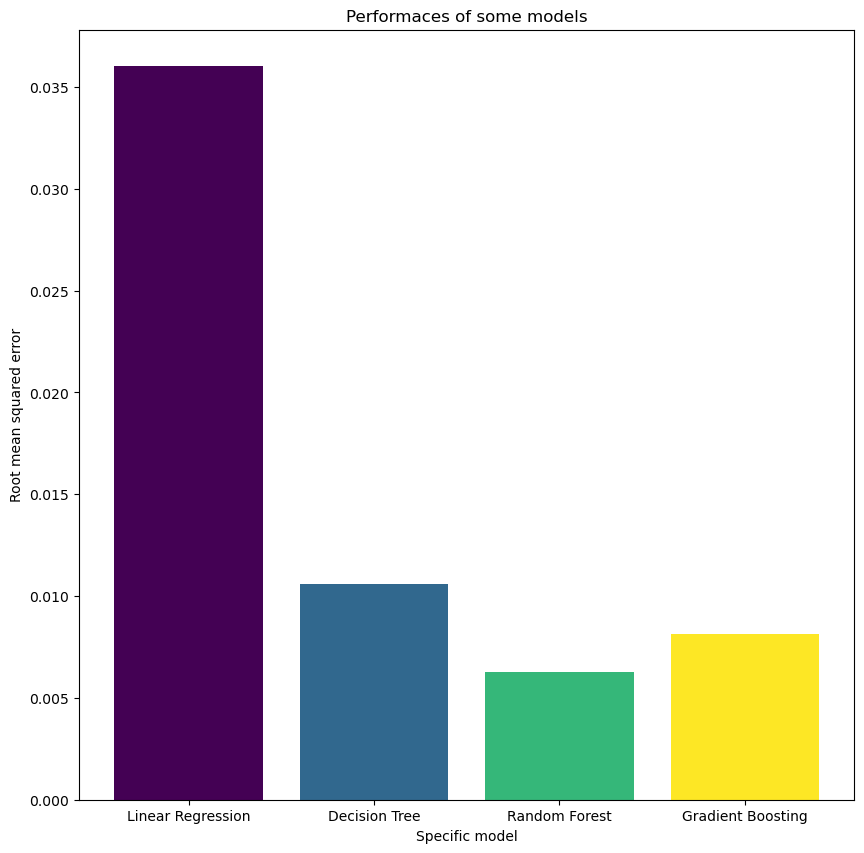

In [ ]:
plt.figure(figsize = (10, 10))
colors = cm.viridis(np.linspace(0, 1, len(performances)))
plt.bar(performances.keys(), performances.values(), color = colors)
plt.xlabel('Specific model')
plt.ylabel('Root mean squared error')
plt.title('Performaces of some models')
plt.show()

#### Vậy ta chọn được mô hình cho kết quả tốt nhất là Gradient Boosting

##### TEST model on test set

In [ ]:
rf_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('RandomForestRegression', RandomForestRegressor())])

rf_pl.fit(X_train, y_train)
y_train_pred = rf_pl.predict(X_train)

In [ ]:
y_test_pred = rf_pl.predict(X_test)
print(f'Train set: MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'Test set: MSE: {mean_squared_error(y_test, y_test_pred)}')

Train set: MSE: 6.264880742984999e-06
Test set: MSE: 1.999785864045414e-05


In [ ]:
# best_model = GradientBoostingRegressor()
# best_model.fit(X_train, y_train)
# y_pred = best_model.predict(X_test)
# rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f'RMSE on test set: {rmse_test}')

In [ ]:
import pickle
pickle.dump(rf_pl, open('model.pkl', 'wb'))